In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots
import random as rd # generating random numbers
import datetime # manipulating date formats

from tqdm import tqdm
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Load sales
sales=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv")
sales.head()

In [ ]:
# you can use this tip to save some memory : #downcast data to save memory : from 134.4+ MB, we went to 61.6+ MB
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

print("-- mem before", sales.info())
sales = downcast_dtypes(sales)
print("-- mem after", sales.info())


# TS des produits les plus répandus

pour chaque produit 

- voir les dates min / max 
- le nombre de dates avec des ventes
- par jour
- aggreger par semaine, par mois






In [5]:
from dateutil.parser import parse
sales['rdate'] = sales['date'].apply(lambda d: parse(d))

In [6]:
df = sales.groupby(by = 'item_id').agg({'rdate': ["min","max"]}).reset_index()
df.head()

item_id      rdate           
                 min        max
0       0 2014-01-09 2014-01-09
1       1 2014-02-04 2014-11-09
2       2 2014-08-24 2014-12-11
3       3 2014-05-07 2014-08-26
4       4 2014-09-19 2014-09-19

In [7]:
df['days'] =  df.apply(lambda d : (d['rdate']['max'] - d['rdate']['min']).days   , axis = 1   )

df.head()

item_id      rdate            days
                 min        max     
0       0 2014-01-09 2014-01-09    0
1       1 2014-02-04 2014-11-09  278
2       2 2014-08-24 2014-12-11  109
3       3 2014-05-07 2014-08-26  111
4       4 2014-09-19 2014-09-19    0

In [8]:
def njours(item_id):
    return len(sales[ (sales.item_id == item_id)   ].rdate.unique())

df['njours'] =  df.item_id.apply(lambda id : njours(id) )
df.head()

item_id      rdate            days njours
                 min        max            
0       0 2014-01-09 2014-01-09    0      1
1       1 2014-02-04 2014-11-09  278      6
2       2 2014-08-24 2014-12-11  109      2
3       3 2014-05-07 2014-08-26  111      2
4       4 2014-09-19 2014-09-19    0      1

In [9]:
df.sort_values(by = ['njours', 'days'], ascending = [False, False],  inplace = True)
df.head()

item_id      rdate             days njours
                    min        max             
5717    5822 2013-01-01 2015-12-10  1073   1033
2263    2308 2013-01-01 2015-12-10  1073   1018
7735    7894 2013-01-01 2015-12-10  1073   1006
5718    5823 2013-01-01 2015-12-10  1073    999
5716    5821 2013-01-03 2015-12-10  1071    987

In [10]:
item_id = 5822
# item_id = 12552
df.head(10)

item_id      rdate             days njours
                     min        max             
5717     5822 2013-01-01 2015-12-10  1073   1033
2263     2308 2013-01-01 2015-12-10  1073   1018
7735     7894 2013-01-01 2015-12-10  1073   1006
5718     5823 2013-01-01 2015-12-10  1073    999
5716     5821 2013-01-03 2015-12-10  1071    987
7698     7856 2013-01-01 2015-12-10  1073    981
11924   12134 2013-01-01 2015-12-10  1073    972
7734     7893 2013-01-01 2015-12-10  1073    970
2749     2808 2013-01-01 2015-12-10  1073    967
1860     1905 2013-01-01 2015-12-09  1072    967

In [19]:
item_ids = df.head(10).item_id.values

def build_ts(item_id):

    df2 = sales[sales.item_id == item_id][['item_cnt_day', 'rdate']].groupby( by = [ 'rdate']  ).sum().reset_index()
    ts = pd.Series(index = df2.rdate, data = df2.item_cnt_day.values)
    return ts


<AxesSubplot:xlabel='rdate'>

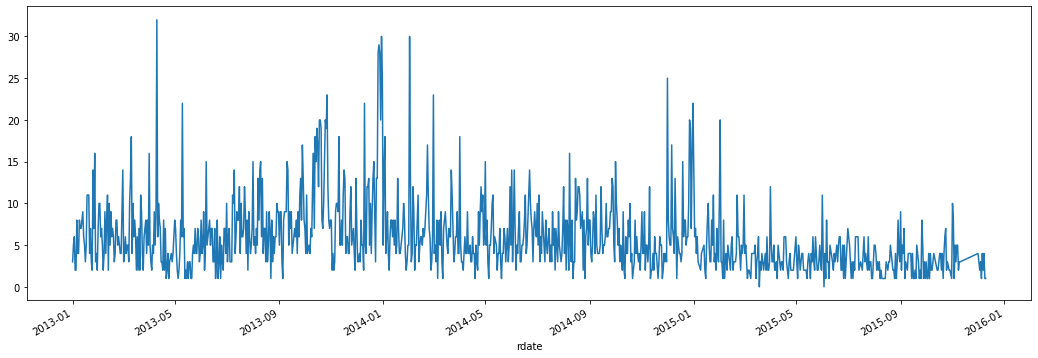

In [21]:
ts = build_ts(item_ids[2])
ts.plot(figsize= (18,6))

# Simple Exponential Smoothing


$ \hat{y}_{t+1} = \alpha . y_t + (1 -\alpha ) . \hat{y}_{t} $


In [23]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
    

    
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(18, 7))
        plt.plot(series.values, "c", label = "Actual", alpha = 0.5)
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);
        


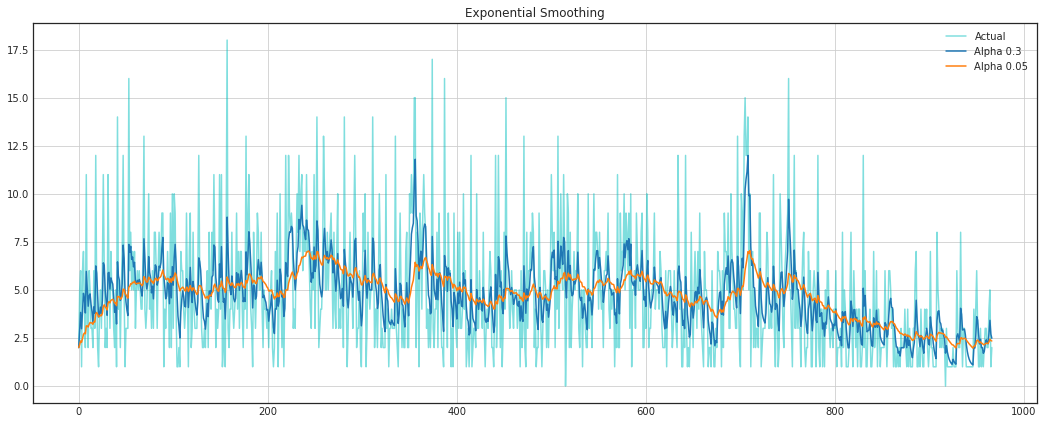

In [27]:
ts = build_ts(item_ids[9])
plotExponentialSmoothing(ts, [0.3, 0.05])


# Double exponential smoothing


In [51]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    level_ = [series[0]]
    trend_ = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        level_.append(level)
        trend_.append(trend)
    return result, level_, trend_

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                r, l, t = double_exponential_smoothing(series, alpha, beta)
                plt.plot(r, label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual", alpha = 0.5, linestyle = '-')
                
                
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)
        
        plt.figure(figsize=(20, 8))
#         plt.plot(series.values, label = "Actual", alpha = 0.5, linestyle = '-')
        for alpha in alphas:
            for beta in betas:
                r, l, t = double_exponential_smoothing(series, alpha, beta)
                plt.plot(l, label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual", alpha = 0.5, linestyle = '-')
                
                
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing - level")
        plt.grid(True)        

        plt.figure(figsize=(20, 8))
#         plt.plot(series.values, label = "Actual", alpha = 0.5, linestyle = '-')
        for alpha in alphas:
            for beta in betas:
                r, l, t = double_exponential_smoothing(series, alpha, beta)
                plt.plot(t, label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual", alpha = 0.5, linestyle = '-')
                
                
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing - trend")
        plt.grid(True)        


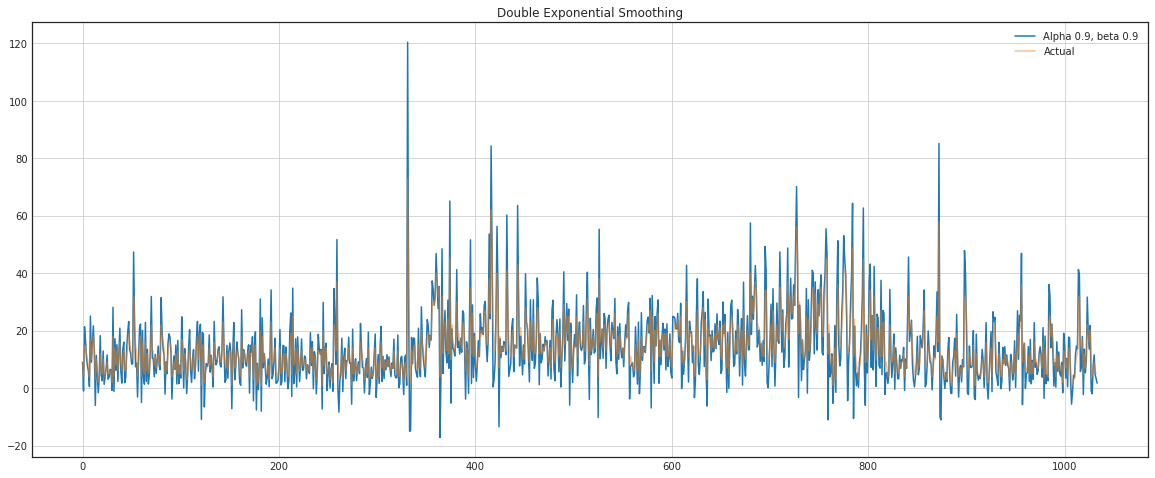

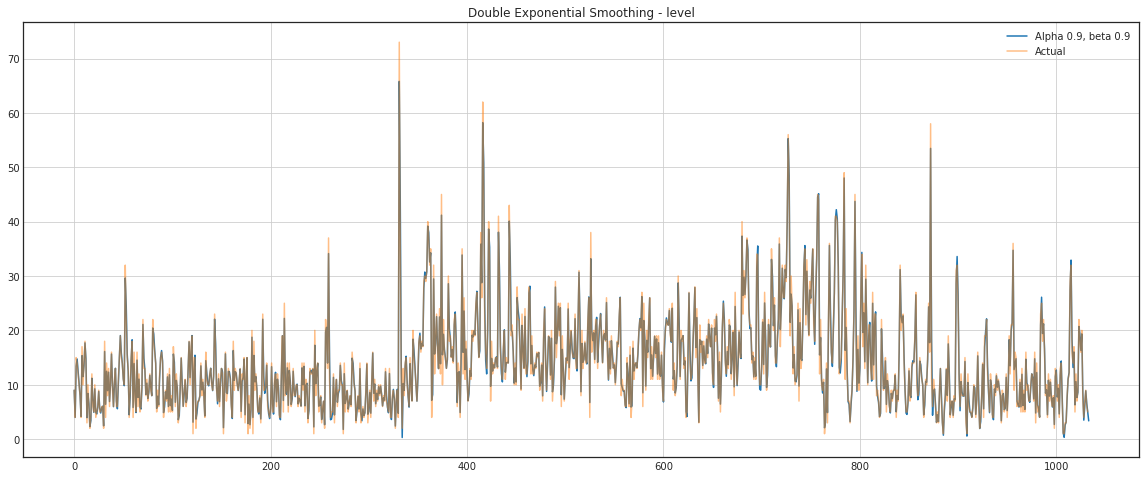

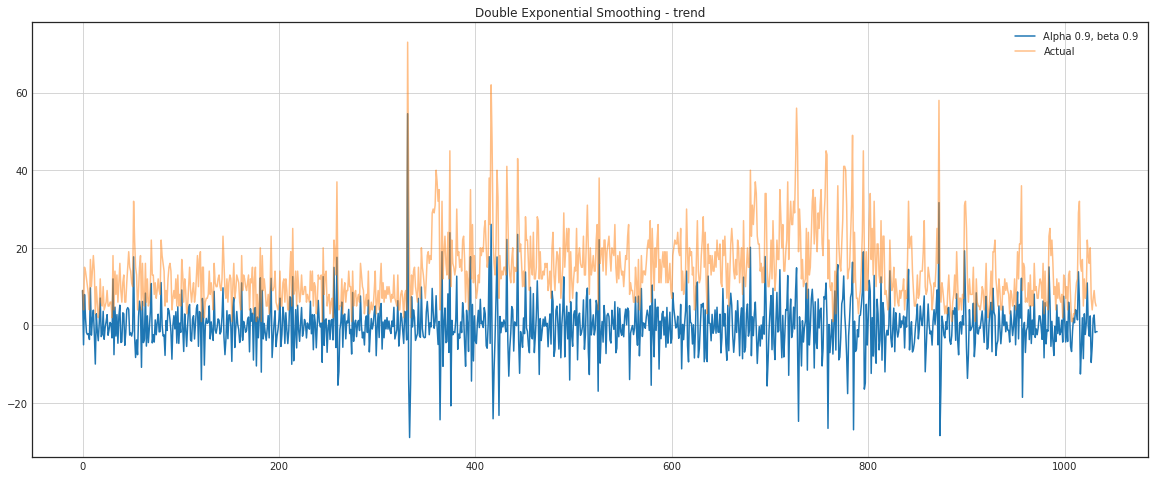

In [52]:
ts = build_ts(item_ids[0])
plotDoubleExponentialSmoothing(ts, alphas=[0.9], betas=[0.9])


In [42]:
r, l, t = double_exponential_smoothing(ts, 0.5, 0.5)


In [43]:
l

[9.0,
 4.0,
 7.0,
 10.0,
 11.5,
 11.375,
 9.96875,
 6.7734375,
 10.982421875,
 11.09130859375,
 12.8729248046875,
 16.045501708984375,
 16.12041473388672,
 10.127767562866211,
 8.849502086639404,
 6.49799382686615,
 3.1977412402629852,
 2.2481796368956566,
 6.211353925988078,
 6.640102589037269,
 6.194451273302548,
 8.17301279710955,
 6.6190403597356635,
 5.6872940511148045,
 5.549597384025674,
 7.09334970447469,
 6.341888438580526,
 5.630685695988312,
 5.617412900695127,
 5.7064232778747535,
 3.8243226469958778,
 10.42719166980747,
 8.6218282637614,
 11.563689494798014,
 10.643697736616819,
 12.022777423372016,
 9.45662291090661,
 9.809389926947254,
 12.783425953230763,
 11.574587478064828,
 8.826521370965652,
 9.245857974674651,
 10.894061782860488,
 8.744648241238284,
 6.983779410117611,
 8.357400142027872,
 11.704860472476035,
 16.202375519581107,
 17.150539163238367,
 16.586986194257406,
 14.158463161202574,
 11.654585854374513,
 20.989000737366855,
 23.408957994521312,
 20.766697

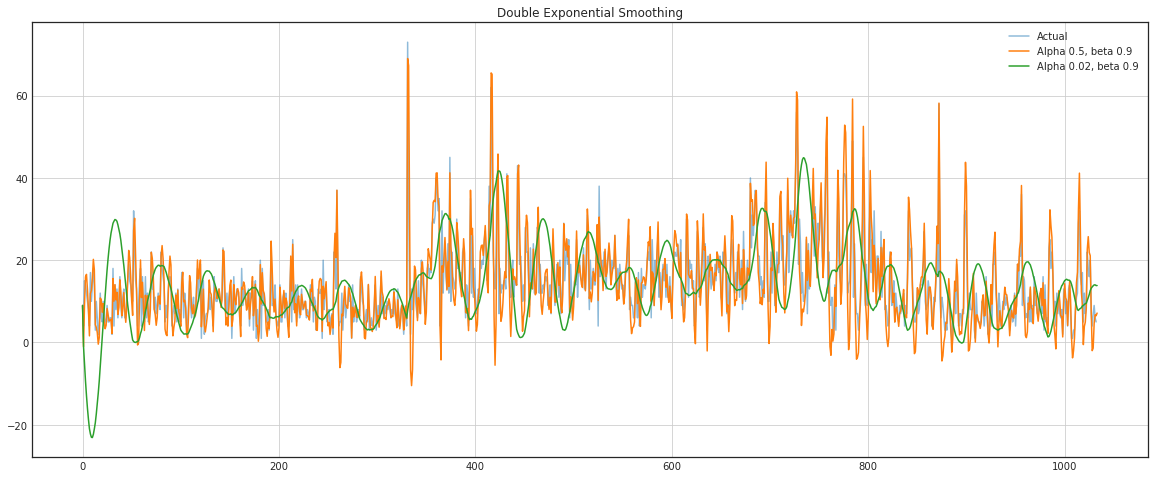

In [36]:
plotDoubleExponentialSmoothing(ts, alphas=[0.5, 0.02], betas=[0.9])

# With statsmodels



In [53]:
ts = build_ts(item_ids[0])

from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing,  Holt

mdl = SimpleExpSmoothing(ts, initialization_method="estimated")
mdl.fit()




/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


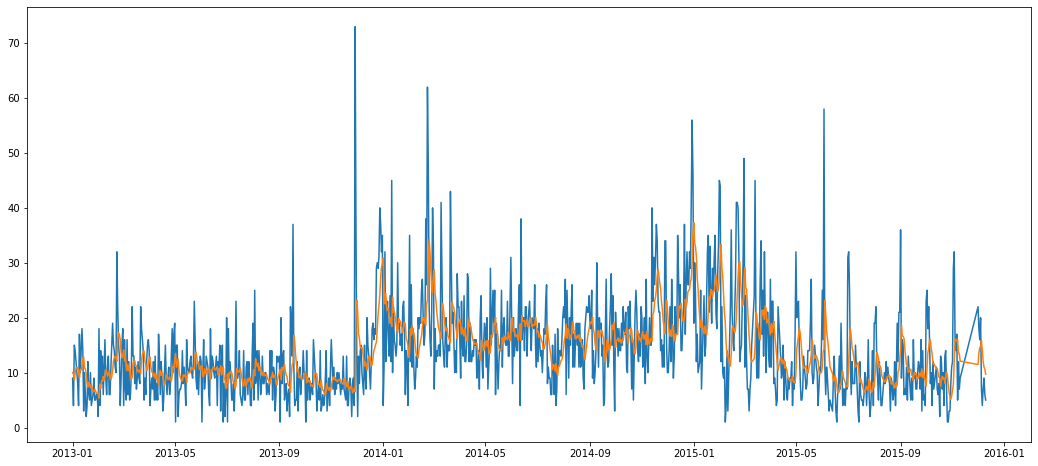

In [62]:
plt.figure(figsize=(18, 8))
plt.plot(ts)
plt.plot(mdl.fittedvalues)
# plt.plot(fcast)


In [60]:
mdl.params

{'smoothing_level': 0.20168100904072964,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 9.986173941017162,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [73]:
fcast = mdl.forecast(12)
fcast

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1033    8.735359
1034    8.735359
1035    8.735359
1036    8.735359
1037    8.735359
1038    8.735359
1039    8.735359
1040    8.735359
1041    8.735359
1042    8.735359
1043    8.735359
1044    8.735359
dtype: float64

In [75]:

# mdl = SimpleExpSmoothing.best_params()
# print('Best Score: ', grid_result.best_score_)

# Holt double exponential smoothing




In [95]:
ts = build_ts(item_ids[9])

mdl = Holt(ts, initialization_method="estimated", damped_trend=True).fit(optimized = True)

print(mdl.params)



{'smoothing_level': 0.03707198368543763, 'smoothing_trend': 0.0, 'smoothing_seasonal': nan, 'damping_trend': 0.9536745322650828, 'initial_level': 3.913880996996586, 'initial_trend': 0.07680606192663732, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


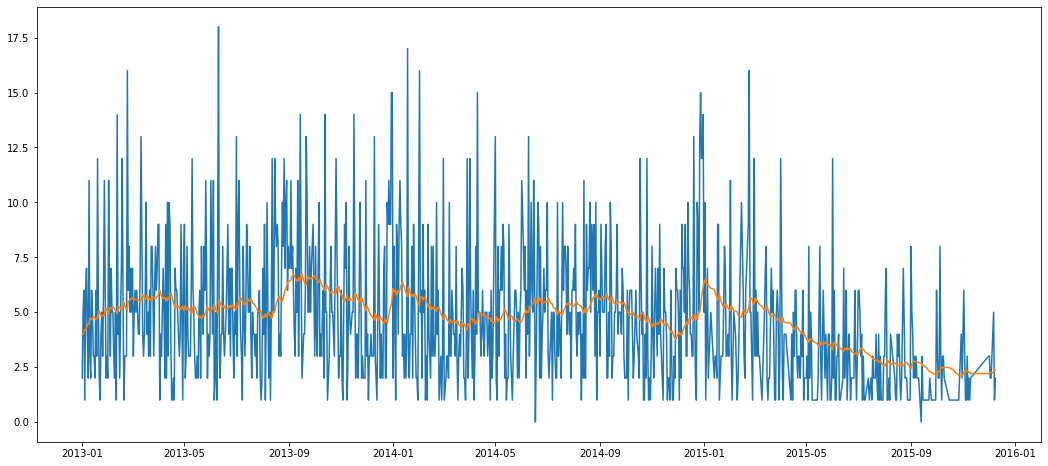

In [96]:
plt.figure(figsize=(18, 8))
plt.plot(ts)
plt.plot(mdl.fittedvalues)

In [97]:
fcast = mdl.forecast(12)
fcast

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


967    2.339333
968    2.339333
969    2.339333
970    2.339333
971    2.339333
972    2.339333
973    2.339333
974    2.339333
975    2.339333
976    2.339333
977    2.339333
978    2.339333
dtype: float64

# Holt Winter

In [102]:
ts = build_ts(item_ids[0])


In [103]:
fit1 = ExponentialSmoothing(ts, seasonal_periods=7, trend='add', seasonal='add', use_boxcox=False, initialization_method="estimated").fit()
fit2 = ExponentialSmoothing(ts, seasonal_periods=7, trend='add', seasonal='mul', use_boxcox=False, initialization_method="estimated").fit()
fit3 = ExponentialSmoothing(ts, seasonal_periods=7, trend='add', seasonal='add', damped_trend=True, use_boxcox=False, initialization_method="estimated").fit()
fit4 = ExponentialSmoothing(ts, seasonal_periods=7, trend='add', seasonal='mul', damped_trend=True, use_boxcox=False, initialization_method="estimated").fit()
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

In [104]:
results

,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,0.229744,2.387889e-01,0.221549,0.238963
$\beta$,0.000040,6.883376e-08,0.000391,0.000004
$\phi$,NaN,NaN,0.832345,0.989412
$\gamma$,0.000462,0.000000e+00,0.000070,0.000008
$l_0$,9.846803,7.980044e+00,10.487169,4.956185
$b_0$,-0.001844,2.112090e-03,-0.250424,0.023490
SSE,59202.785373,5.910284e+04,59186.736359,59101.950569


In [106]:
fit1 = ExponentialSmoothing(ts, seasonal_periods=28, trend='add', seasonal='add', use_boxcox=False, initialization_method="estimated").fit()
fit2 = ExponentialSmoothing(ts, seasonal_periods=28, trend='add', seasonal='mul', use_boxcox=False, initialization_method="estimated").fit()
fit3 = ExponentialSmoothing(ts, seasonal_periods=28, trend='add', seasonal='add', damped_trend=True, use_boxcox=False, initialization_method="estimated").fit()
fit4 = ExponentialSmoothing(ts, seasonal_periods=28, trend='add', seasonal='mul', damped_trend=True, use_boxcox=False, initialization_method="estimated").fit()
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]
results

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,0.215595,0.213664,0.199508,0.215799
$\beta$,0.000899,0.000351,0.000444,0.000088
$\phi$,NaN,NaN,0.800000,0.904202
$\gamma$,0.011938,0.001232,0.000000,0.004418
$l_0$,10.215712,1.490581,11.353392,1.299869
$b_0$,-0.002687,-0.000038,-0.497171,-0.021386
SSE,58569.323910,56962.680793,57669.367048,57174.549720


In [107]:
fit1 = ExponentialSmoothing(ts, seasonal_periods=365, trend='add', seasonal='add', use_boxcox=False, initialization_method="estimated").fit()
fit2 = ExponentialSmoothing(ts, seasonal_periods=365, trend='add', seasonal='mul', use_boxcox=False, initialization_method="estimated").fit()
fit3 = ExponentialSmoothing(ts, seasonal_periods=365, trend='add', seasonal='add', damped_trend=True, use_boxcox=False, initialization_method="estimated").fit()
fit4 = ExponentialSmoothing(ts, seasonal_periods=365, trend='add', seasonal='mul', damped_trend=True, use_boxcox=False, initialization_method="estimated").fit()
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]
results

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,4.376611e-02,0.005001,0.045857,0.005700
$\beta$,1.340648e-09,0.000100,0.000698,0.000114
$\phi$,NaN,NaN,0.841214,0.989253
$\gamma$,6.369294e-07,0.461963,0.002100,0.283151
$l_0$,6.138194e+00,10.528549,9.242446,10.479352
$b_0$,7.976618e-03,-0.028493,-0.627492,-0.051292
SSE,3.861492e+04,108604.632565,38721.936315,67119.366844


In [108]:
fit1 = ExponentialSmoothing(ts, seasonal_periods=365, trend='add', seasonal='add', use_boxcox=False, initialization_method="estimated").fit(smoothing_trend = 0)
fit2 = ExponentialSmoothing(ts, seasonal_periods=365, trend='add', seasonal='mul', use_boxcox=False, initialization_method="estimated").fit(smoothing_trend = 0)
fit3 = ExponentialSmoothing(ts, seasonal_periods=365, trend='add', seasonal='add', damped_trend=True, use_boxcox=False, initialization_method="estimated").fit(smoothing_trend = 0)
fit4 = ExponentialSmoothing(ts, seasonal_periods=365, trend='add', seasonal='mul', damped_trend=True, use_boxcox=False, initialization_method="estimated").fit(smoothing_trend = 0)
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]
results




/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,0.043433,0.005002,0.036522,0.007184
$\beta$,0.000000,0.000000,0.000000,0.000000
$\phi$,NaN,NaN,0.994572,0.989519
$\gamma$,0.000062,0.450111,0.000126,0.283119
$l_0$,6.152860,10.528381,4.352979,10.498962
$b_0$,0.007829,-0.026681,0.066895,-0.022610
SSE,38619.084827,105685.247813,38496.061568,67488.728959


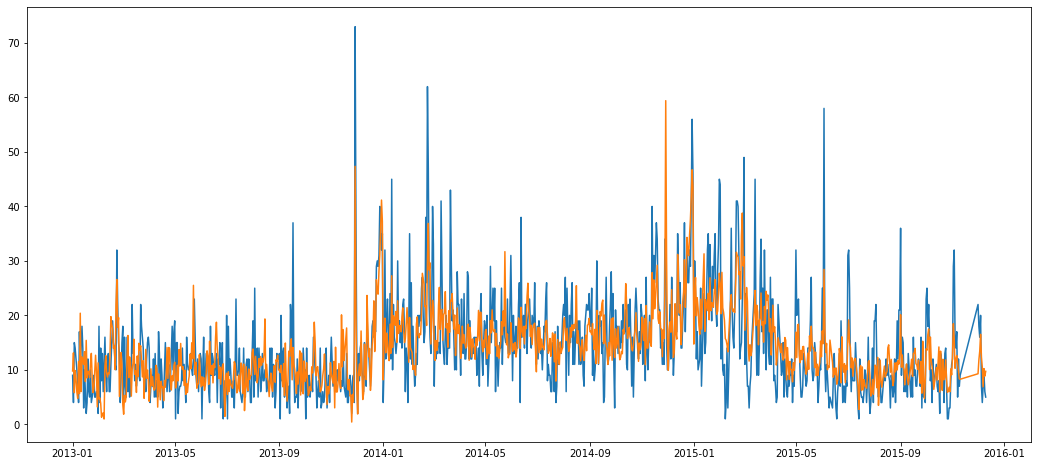

In [109]:
plt.figure(figsize=(18, 8))
plt.plot(ts)
plt.plot(fit1.fittedvalues)



/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


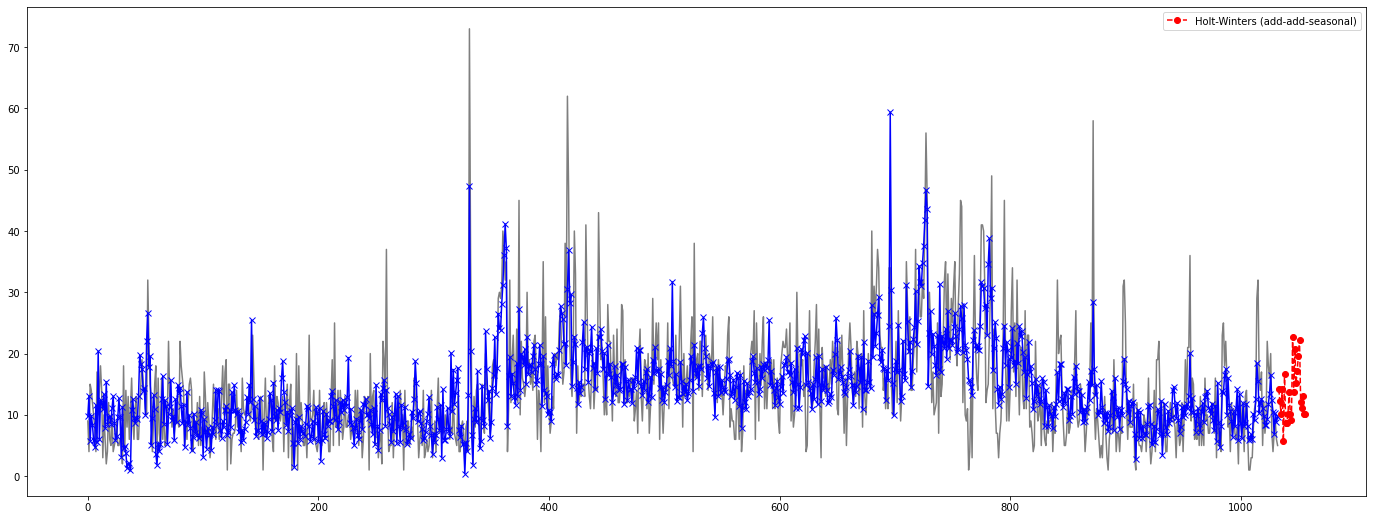

In [123]:
fig, ax = plt.subplots(1,1,figsize=(24,9))

plt.plot(ts.values, color='black', alpha = 0.5)
plt.plot(fit1.fittedvalues.values, marker='x', color='blue')
fit1.forecast(24).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)

plt.show()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


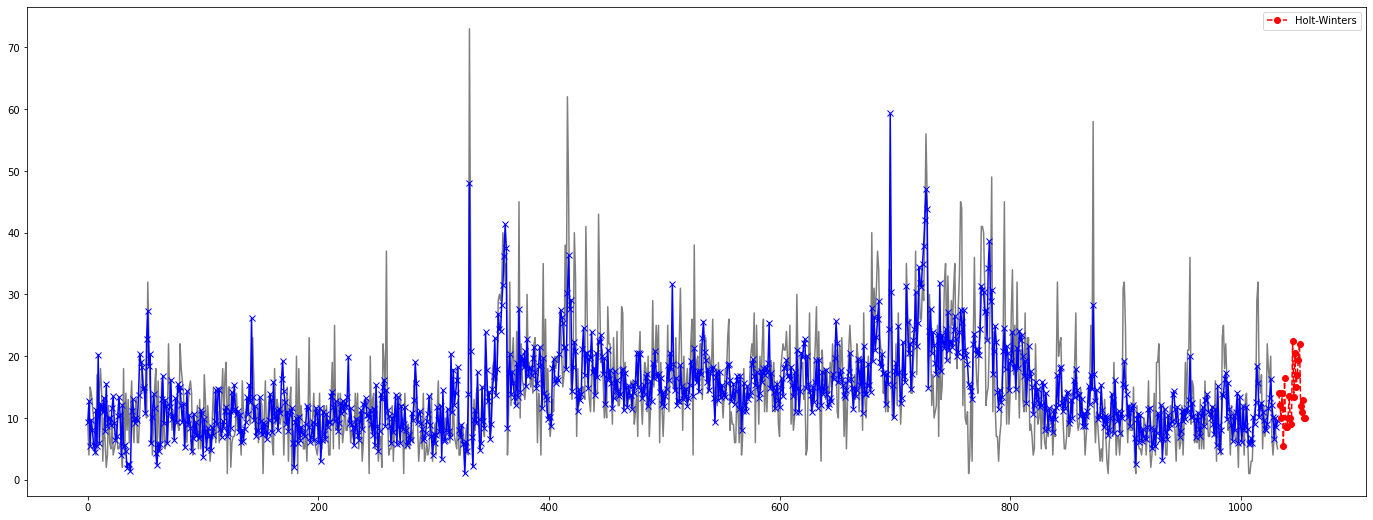

In [125]:
fig, ax = plt.subplots(1,1,figsize=(24,9))

plt.plot(ts.values, color='black', alpha = 0.5)
plt.plot(fit3.fittedvalues.values, marker='x', color='blue')
fit3.forecast(24).rename('Holt-Winters').plot(ax=ax, style='--', marker='o', color='red', legend=True)

plt.show()

In [116]:
fit1.fittedvalues

rdate
2013-01-01     9.790699
2013-01-02    13.119449
2013-01-03     5.806645
2013-01-04     9.873806
2013-01-05     8.402148
                ...    
2015-12-06    10.498386
2015-12-07     6.877015
2015-12-08    10.224597
2015-12-09     8.850260
2015-12-10     9.725003
Length: 1033, dtype: float64